In [22]:
from load_h5 import Dataset4h5
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import h5py
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import torch

In [66]:
dataset = Dataset4h5('/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5', num_image=8, num_redshift=512, HII_DIM=64, rescale=False, dim=3)

dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
1000 images can be loaded
field.shape = (64, 64, 514)
params keys = [b'ION_Tvir_MIN', b'HII_EFF_FACTOR']
loading 8 images randomly
images loaded: (8, 1, 64, 64, 512)
params loaded: (8, 2)
images rescaled to [0.0, 42.617393493652344]
params rescaled to [4.4, 131.341]


In [67]:
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64-CUB8-4.4-131.341.h5") as f:
    print(f.keys())
    print(f['redshifts_distances'])
    los = f['redshifts_distances'][:,-512:]

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
<HDF5 dataset "redshifts_distances": shape (2, 514), type "<f8">


In [68]:
los.shape

(2, 512)

In [69]:
dataloader = DataLoader(dataset, batch_size=8)

In [70]:
len(dataloader)

1

In [71]:
x, c = next(iter(dataloader))

In [72]:
x.shape

torch.Size([8, 1, 64, 64, 512])

In [73]:
c.shape

torch.Size([8, 2])

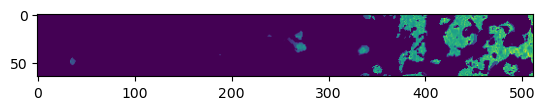

In [74]:
plt.imshow(x[0,0,:,0,:])

In [75]:
print(x.shape)
Tb = torch.mean(x, axis=2)
print(Tb.shape)
Tb = torch.mean(Tb, axis=2)
print(Tb.shape)
# print(Tb.shape)
# print(Tb[:,0,:].shape)
# print(Tb[:10, 0, :].shape)

torch.Size([8, 1, 64, 64, 512])
torch.Size([8, 1, 64, 512])
torch.Size([8, 1, 512])


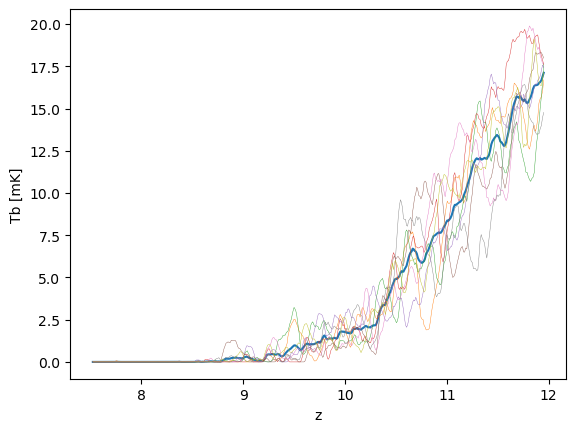

In [76]:
plt.plot(los[0,:], Tb[:,0,:].mean(axis=0))
for i in range(8):
    plt.plot(los[0,:], Tb[i,0,:], lw=0.3)
# plt.plot(los[0,:], Tb[1,0,:])
# plt.plot(los[0,:], Tb[2,0,:])
# plt.yscale('log')
plt.ylabel('Tb [mK]')
plt.xlabel('z')
plt.show()

In [77]:
x.shape

torch.Size([8, 1, 64, 64, 512])

In [31]:
# import numpy as np
# import matplotlib.pyplot as plt

# def compute_3d_power_spectrum(density_field, box_size):
#     """
#     计算三维密度场的物质功率谱
    
#     参数:
#     density_field (numpy.ndarray): 三维密度场数组
#     box_size (float): 盒子的物理大小（单位Mpc/h）

#     返回:
#     k_vals (numpy.ndarray): 波数
#     Pk (numpy.ndarray): 功率谱
#     """
#     # 获取密度场的形状
#     Nx, Ny, Nz = density_field.shape
#     N = Nx  # 假设立方体

#     # 计算傅里叶变换
#     delta_k = np.fft.fftn(density_field)
#     delta_k = np.fft.fftshift(delta_k)  # 将零频移到中心

#     # 计算功率谱
#     Pk = np.abs(delta_k) ** 2 / (N ** 3)

#     # 创建波数k的网格
#     kx = np.fft.fftfreq(N, d=box_size / N)
#     ky = np.fft.fftfreq(N, d=box_size / N)
#     kz = np.fft.fftfreq(N, d=box_size / N)
#     kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
#     k = np.sqrt(kx**2 + ky**2 + kz**2)

#     # 将结果移回零频在中心
#     k = np.fft.fftshift(k)
#     Pk = np.fft.fftshift(Pk)
#     mask = k > 0
#     k = k[mask]
#     Pk = Pk[mask]

#     # 平均功率谱
#     k_flat = k.flatten()
#     Pk_flat = Pk.flatten()

#     # 创建波数的对数间隔
#     k_bins = np.logspace(np.log10(k_flat.min()), np.log10(k_flat.max()), num=20)
#     k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
#     Pk_vals = np.zeros_like(k_vals)

#     # 在每个波数区间内进行平均
#     for i in range(len(k_bins) - 1):
#         mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
#         if np.any(mask):
#             Pk_vals[i] = np.mean(Pk_flat[mask])

#     return k_vals, Pk_vals

# # 示例三维密度场
# N = 64  # 密度场的大小
# box_size = 100.0  # 盒子大小（单位Mpc/h）
# density_field = np.random.randn(N, N, N)  # 示例密度场，可以替换为实际数据

# # 计算物质功率谱
# k_vals, Pk_vals = compute_3d_power_spectrum(density_field, box_size)
# print(k_vals.shape)
# print(Pk_vals.shape)
# print(k_vals)
# print(Pk_vals)

# # 绘制功率谱
# plt.figure(figsize=(8, 6))
# plt.loglog(k_vals, Pk_vals, 'b-')
# plt.xlabel('k [h/Mpc]')
# plt.ylabel('P(k) [(Mpc/h)^3]')
# plt.title('Matter Power Spectrum')
# plt.grid(True)
# plt.show()


In [32]:
x.shape

torch.Size([8, 1, 64, 512])

In [63]:
test = np.random.randn(4,6)
print(test.shape)
print(test[test>0].shape)
print(test)
print(test[test>0])

(4, 6)
(15,)
[[ 0.53975973 -0.84204617  1.42889113 -0.09738966 -0.37970818 -0.35503457]
 [ 0.32875735  1.53718679 -0.2365013   0.2823807   1.53696493 -0.66972945]
 [ 0.10889162  0.91431333  0.16015588  0.52035998  1.80944618  0.54208654]
 [-0.70190854  0.18372627 -1.84199925  0.20049327  0.43315308 -1.52467531]]
[0.53975973 1.42889113 0.32875735 1.53718679 0.2823807  1.53696493
 0.10889162 0.91431333 0.16015588 0.52035998 1.80944618 0.54208654
 0.18372627 0.20049327 0.43315308]


print(density_field.shape) torch.Size([64, 512])
Pk.shape = (64, 512)
before meshgrid, print(kx.shape, ky.shape) (64,) (512,)
print(box_size_x, Nx, box_size_z, Nz) 128.0 64 1024.0 512
print(kx.shape, ky.shape) (64, 512) (64, 512)
before mask, print(k.shape, Pk.shape) (64, 512) (64, 512)
k, Pk [[0.35355339 0.35286353 0.35217503 ... 0.35148789 0.35217503 0.35286353]
 [0.34807296 0.34737222 0.34667281 ... 0.34597475 0.34667281 0.34737222]
 [0.342683   0.34197122 0.34126074 ... 0.34055158 0.34126074 0.34197122]
 ...
 [0.33738786 0.33666488 0.33594318 ... 0.33522277 0.33594318 0.33666488]
 [0.342683   0.34197122 0.34126074 ... 0.34055158 0.34126074 0.34197122]
 [0.34807296 0.34737222 0.34667281 ... 0.34597475 0.34667281 0.34737222]] [[1.99888195e+05 1.36532063e+05 5.05297794e+04 ... 9.34837716e+03
  5.05297794e+04 1.36532063e+05]
 [1.19445051e+03 1.37584285e+02 1.88703465e+03 ... 7.98861279e+03
  9.47800081e+03 3.40048487e+03]
 [3.49734727e+03 1.57879977e+03 4.69584203e+02 ... 7.84533435e+0

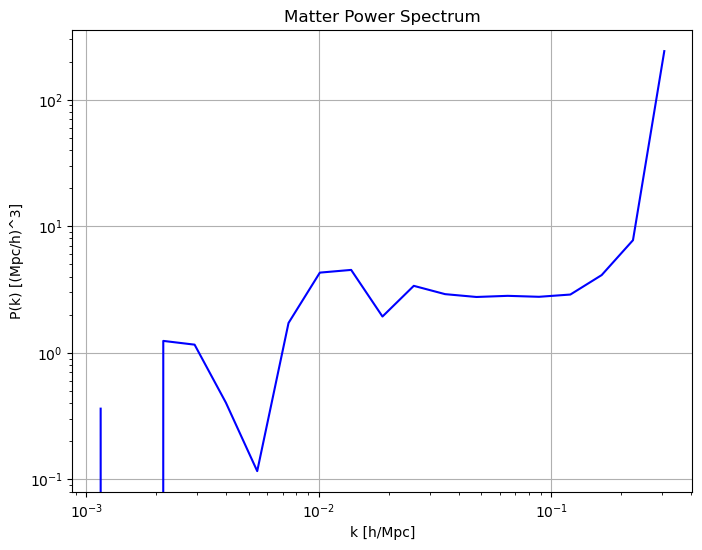

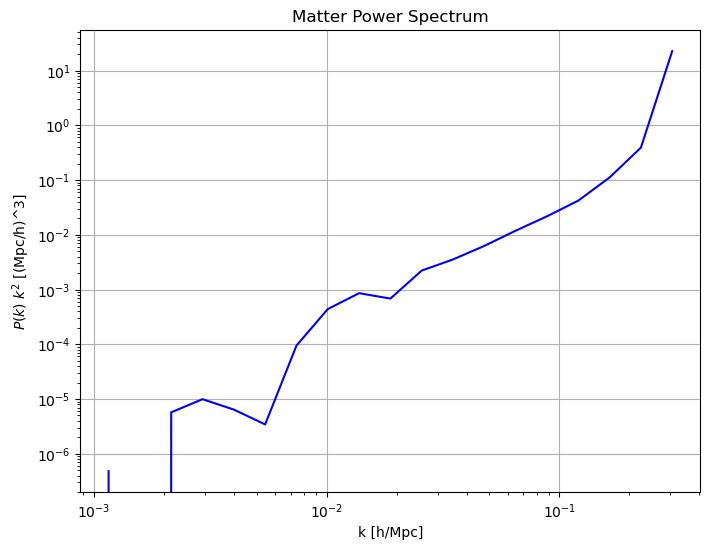

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def compute_2d_power_spectrum(density_field, box_size_x, box_size_z):
    """
    计算三维密度场的物质功率谱
    
    参数:
    density_field (numpy.ndarray): 三维密度场数组
    box_size (float): 盒子的物理大小（单位Mpc/h）

    返回:
    k_vals (numpy.ndarray): 波数
    Pk (numpy.ndarray): 功率谱
    """
    # 获取密度场的形状
    Nx, Nz = density_field.shape
    # N = Nx  # 假设立方体

    # 计算傅里叶变换
    delta_k = np.fft.fftn(density_field)
    delta_k = np.fft.fftshift(delta_k)  # 将零频移到中心

    # 计算功率谱
    Pk = np.abs(delta_k) ** 2 / (Nx * Nz)
    print("Pk.shape =", Pk.shape)

    # 创建波数k的网格
    kx = np.fft.fftfreq(Nx, d=box_size_x / Nx)
    ky = np.fft.fftfreq(Nz, d=box_size_z / Nz)
    # kz = np.fft.fftfreq(N, d=box_size / N)
    print("before meshgrid, print(kx.shape, ky.shape)", kx.shape, ky.shape)
    kx, ky = np.meshgrid(kx, ky, indexing='ij')

    print("print(box_size_x, Nx, box_size_z, Nz)", box_size_x, Nx, box_size_z, Nz)
    print("print(kx.shape, ky.shape)", kx.shape, ky.shape)

    k = np.sqrt(kx**2 + ky**2)

    # 将结果移回零频在中心
    k = np.fft.fftshift(k)
    Pk = np.fft.fftshift(Pk)
    print("before mask, print(k.shape, Pk.shape)", k.shape, Pk.shape)
    k_flat = k.flatten()
    Pk_flat = Pk.flatten()
    mask = k_flat > 0
    # print("before mask, k =", k)
    k_flat = k_flat[mask]
    Pk_flat = Pk_flat[mask]

    print("k, Pk", k, Pk)
    print("after mask, print(k.shape, Pk.shape)", k.shape, Pk.shape)
    # 平均功率谱

    print("after flatten, print(k_flat.shape, Pk_flat.shape)", k_flat.shape, Pk_flat.shape)

    # 创建波数的对数间隔
    k_bins = np.logspace(np.log10(k_flat.min()), np.log10(k_flat.max()), num=20)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    print("k_vals =", k_vals)
    Pk_vals = np.zeros_like(k_vals)

    # 在每个波数区间内进行平均
    for i in range(len(k_bins) - 1):
        mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
        if np.any(mask):
            Pk_vals[i] = np.mean(Pk_flat[mask])

    return k_vals, Pk_vals

# 示例三维密度场
# N = 64  # 密度场的大小
box_size_x = 128.0  # 盒子大小（单位Mpc/h）
box_size_z = 1024.0  # 盒子大小（单位Mpc/h）
density_field = x[0,0,:,0,:]#np.random.randn(N, N)  # 示例密度场，可以替换为实际数据
print("print(density_field.shape)", density_field.shape)

# 计算物质功率谱
k_vals, Pk_vals = compute_2d_power_spectrum(density_field, box_size_x, box_size_z)
print("print(k_vals.shape, Pk_vals.shape)", k_vals.shape, Pk_vals.shape)
# print(k_vals)
# print(Pk_vals)

# 绘制功率谱

plt.figure(figsize=(8, 6))
print("k_vals, Pk_vals", k_vals, Pk_vals,)
plt.loglog(k_vals, Pk_vals, 'b-')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)^3]')
plt.title('Matter Power Spectrum')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.loglog(k_vals, Pk_vals*k_vals**2, 'b-')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$P(k)\ k^2$ [(Mpc/h)^3]')
plt.title('Matter Power Spectrum')
plt.grid(True)
plt.show()

Pk.shape = (64, 64, 512)
k.shape = (64, 64, 512)


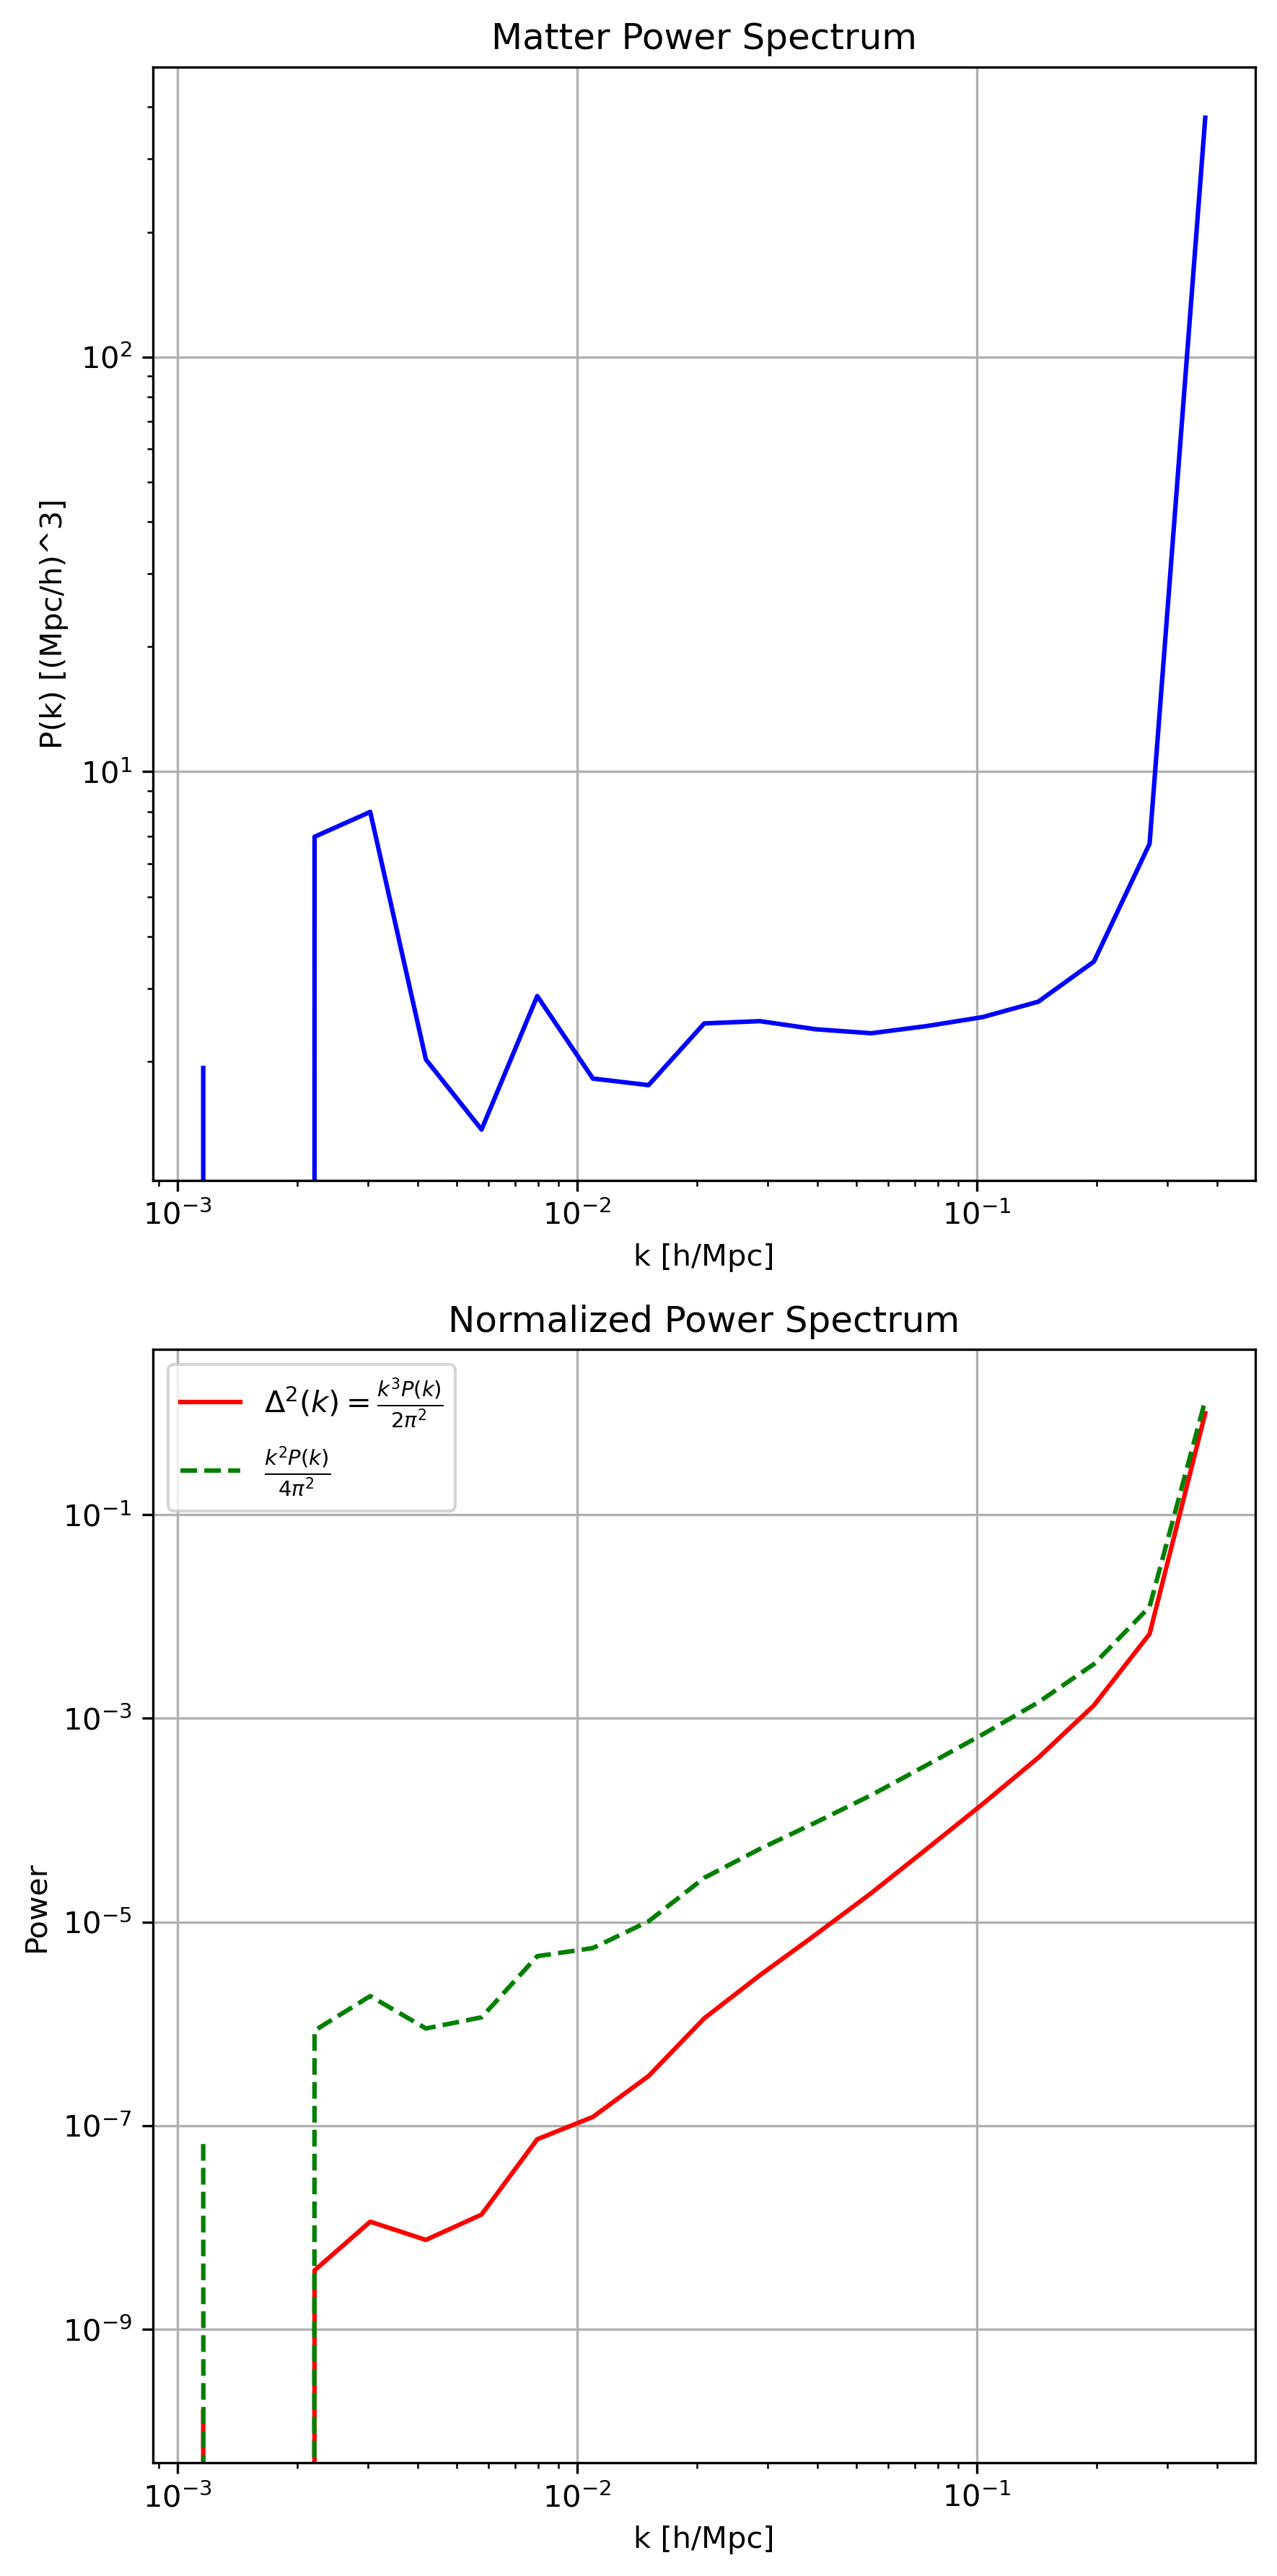

In [95]:
import numpy as np
import matplotlib.pyplot as plt

def compute_3d_power_spectrum(density_field, box_size):
    """
    计算三维密度场的物质功率谱
    
    参数:
    density_field (numpy.ndarray): 三维密度场数组
    box_size (tuple): 盒子的物理大小 (Lx, Ly, Lz) 单位为Mpc/h

    返回:
    k_vals (numpy.ndarray): 波数
    Pk (numpy.ndarray): 功率谱
    """
    Nx, Ny, Nz = density_field.shape
    Lx, Ly, Lz = box_size

    # 计算傅里叶变换
    delta_k = np.fft.fftn(density_field)
    delta_k = np.fft.fftshift(delta_k)  # 将零频移到中心

    # 计算功率谱
    Pk = np.abs(delta_k) ** 2 / (Nx * Ny * Nz)
    print("Pk.shape =", Pk.shape)
    # 创建波数k的网格
    kx = np.fft.fftfreq(Nx, d=Lx / Nx)
    ky = np.fft.fftfreq(Ny, d=Ly / Ny)
    kz = np.fft.fftfreq(Nz, d=Lz / Nz)
    kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
    k = np.sqrt((kx**2) + (ky**2) + (kz**2))
    print("k.shape =", k.shape)
    # 将结果移回零频在中心
    k = np.fft.fftshift(k)
    Pk = np.fft.fftshift(Pk)

    # 排除零波数，避免对数变换出错
    k = k.flatten()
    Pk = Pk.flatten()
    mask = k > 0
    k = k[mask]
    Pk = Pk[mask]

    # 创建波数的对数间隔
    k_bins = np.logspace(np.log10(k.min()), np.log10(k.max()), num=20)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    Pk_vals = np.zeros_like(k_vals)

    # 在每个波数区间内进行平均
    for i in range(len(k_bins) - 1):
        bin_mask = (k >= k_bins[i]) & (k < k_bins[i+1])
        if np.any(bin_mask):
            Pk_vals[i] = np.mean(Pk[bin_mask])

    return k_vals, Pk_vals

# 示例三维密度场
Nx, Ny, Nz = 64, 64, 512  # 密度场的大小，长方体
box_size = (128.0, 128.0, 1024.0)  # 盒子大小（单位Mpc/h），对应于 (Lx, Ly, Lz)
density_field = x[0,0,:,:,:]#np.random.randn(Nx, Ny, Nz)  # 示例密度场，可以替换为实际数据

# 计算物质功率谱
k_vals, Pk_vals = compute_3d_power_spectrum(density_field, box_size)

# 计算Delta^2(k)
Delta2_vals = k_vals**3 * Pk_vals / (2 * np.pi**2)

# 计算 k^2 P(k) / (4 * pi^2)
k2Pk_vals = k_vals**2 * Pk_vals / (4 * np.pi**2)

# 绘制功率谱
plt.figure(figsize=(6, 12), dpi=300)

plt.subplot(2, 1, 1)
plt.loglog(k_vals, Pk_vals, 'b-')
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)^3]')
plt.title('Matter Power Spectrum')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.loglog(k_vals, Delta2_vals, 'r-', label='$\\Delta^2(k) = \\frac{k^3 P(k)}{2\\pi^2}$')
plt.loglog(k_vals, k2Pk_vals, 'g--', label='$\\frac{k^2 P(k)}{4\\pi^2}$')
plt.xlabel('k [h/Mpc]')
plt.ylabel('Power')
plt.title('Normalized Power Spectrum')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
